___
<img style="float: right; margin: 15px 15px 15px 15px;" src="https://communist.red/wp-content/uploads/2017/08/Anarchist_flag.png" width="300px" height="180px" />


# <font color= #bbc28d> **Skip-gram & CBOW Word Embeddings** </font>
#### <font color= #2E9AFE> `Lab 2 – Text Mining`</font>
- <Strong> Sofía Maldonado, Diana Valdivia & Viviana Toledo </Strong>
- <Strong> Fecha </Strong>: 20/10/2025 

___

<p style="text-align:right;"> Imagen recuperada de: https://communist.red/wp-content/uploads/2017/08/Anarchist_flag.png</p>

In [1]:
# General Libraries
import numpy as np
import re
from collections import Counter
import random
import spacy
import pickle

# Modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Evaluation
from sklearn.metrics.pairwise import cosine_similarity

#Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# <font color= #bbc28d> **Introduction** </font>

Natural Language Processing encompasses all the tasks related to making computers understand human language, of which, word embeddings are a useful tool for achieving this goal. Word embeddings are a numerical representation of words, which allows computers to encode language into vectors which can be visualized in different dimensions.

A common representation that word embeddings use is one-hot encoding, which vectorizes each word using binary numbers in a `vector of dimensionality 1 x corpus length`, for example:  

<div style="background-color: white; text-align: center; padding: 1em; margin-bottom: 0.5em;">
<img src="https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-40dd0ac8f7ba6930347fc88ac01ef5b8_l3.svg" style="display: inline-block;"/>

<div style="background-color: white; text-align: center; padding: 0.5em;">
    <img src="https://www.baeldung.com/wp-content/ql-cache/quicklatex.com-aca3b72bad8941a430b71c9946bf01b3_l3.svg" style="display: inline-block;"/>
</div>

However, such encoding can quickly scale up with large vocabularies, resulting in a curse of dimensionality. Additionally, the embeddings are susceptible to changes in the corpora size, and the vectors dont encapsulate word meaning. The one-hot encoding 'indexes' words, but is unable to capture semantic and syntantic information; the values in the vectors must somehow quantify the meaning of the words they represent.

To solve this problem, Word2Vec was introduced, a technique which generates embeddings based on word similarity, allowing them to be close to each other in a vectorized space in terms of cosine distance. There are two main algorithms to obtain a Word2Vec implementation: Continuous Bag of Words (CBOW) and Skip-Gram, which make use of neural network models.

In this notebook, we will explore both models and implement them on a corpus about Anarchy on Wikipedia.

# <font color= #bbc28d> **Preprocessing** </font>

In [2]:
# Read Wikipedia file 
with open(r"text8", "r", encoding="utf-8") as f:
    text = f.read()

The preprocessing task involves:

- Normalization of Corpus (ensuring words are in lowercase)

- Word extraction

- Tokenization by whitespace

- Remove single-letter tokens

- Select a corpus of 50,000 words

In [3]:
# Normalize data
# Convert every word to lowercase
text = text.lower()

# Keep only the words, leave the rest as whitespace
text = re.sub(r"[^a-z\s]", "", text)

# Tokenize by whitespace
tokens = text.split()

# Keep only more than single letter words
tokens = [w for w in tokens if len(w) > 1]

# Keep first 50k words
tokens_models = tokens[:50_000]

Next, we create a vocabulary from those words: 

In [4]:
# Create a vocabulary based on the clean corpora
vocab = sorted(list(set(tokens_models)))
vocab_set = set(vocab)

After creating a vocabulary, we build up a dictionary of word-index pairs for the embeddings:

In [5]:
# Create word-index dictionaries
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for word, i in word_to_idx.items()}

length = len(vocab)
print(f"Vocabulary Size: {length}")

Vocabulary Size: 7979


And finally, we can visualize the id of the tokens:

In [6]:
tokens_idx = [word_to_idx[w] for w in tokens_models if w in vocab_set]
tokens_idx[:10]

[362, 5086, 543, 7161, 4983, 39, 2868, 7568, 203, 2293]

# <font color= #bbc28d> **Modeling** </font>

CBOW and Skip-gram are algorithms that work on word pairs, meaning, for labeling word similarity, words are paired together and then analyzed. The pairing is done by a window-size, which selects words behind and after the target, and pairs them together. Thus, this will be the first step in our respective modelings.

Both models are going to be implemented using Pytorch, since they are, essentially, neural networks. Taking advantage of this, we will first check if cuda is available. If it is, we're going to run our models in the computer's gpu, as it speeds up training:

In [26]:
# PyTorch Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(f'Using device: {device}')

Using device: cuda


# <font color= #bbc28d> **1. Skip-Gram** </font>

The Skip-Gram algorithm tries to extract the semantics of words (context) by `predicting the context words using the main word`. By picking the word pais of the target word, each of them is run through a neural network model with one hidden layer:

<p align= "center">
    <img src='https://www.baeldung.com/wp-content/uploads/sites/4/2021/03/Baeldung-word-embeddings-1-656x1024-1.png' width="420px" height="560px">
</p>

Firstly, we need to generate the skipgram pairs. We're using a word window of 2 to 5 words:

In [8]:
def generate_skipgram_pairs(tokens_idx, min_window=2, max_window=5):
    # Guardar los pares en una lista
    pairs = []
    # Rango la longitud de el vocabulario/texto
    n = len(tokens_idx)
    for i in range(n):
        # Elegir nuestro target
        target = tokens_idx[i]
        # Ventana random entre 2 y 5
        window_size = random.randint(min_window, max_window)
        # Posiciones de inicio y fin de la window
        start = max(i - window_size, 0)
        end = min(i + window_size + 1, n)
        for j in range(start, end):
            #Skipear la target
            if j != i:
                context = tokens_idx[j]
                pairs.append((target, context))
    return pairs

skip_pairs = generate_skipgram_pairs(tokens_idx, min_window=2, max_window=5)

In [11]:
# Convert Skip-Gram pairs to text
skipgram_pairs_words = [
    (idx_to_word[target], idx_to_word[context])
    for target, context in skip_pairs
]

for i in range(5):
    print(f"Target: {skipgram_pairs_words[i][0]}  -->  Context: {skipgram_pairs_words[i][1]}")

Target: anarchism  -->  Context: originated
Target: anarchism  -->  Context: as
Target: anarchism  -->  Context: term
Target: anarchism  -->  Context: of
Target: anarchism  -->  Context: abuse


After pairing the words, we can proceed to model the data: 

In [27]:
# Constants
embedding_dim = 100
vocab_size = len(vocab)

# ==========================
# Model Definition
# ==========================
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, centers):
        # centers: tensor [batch_size]
        embeds = self.embeddings(centers)  # [batch_size, emb_dim]
        out = self.output(embeds)
        return out

# ==========================
# Data Loader
# ==========================  
generator = torch.Generator(device=device)              # Set generator
# Create dataset in CPU 
skipgram_targets = torch.tensor([t for t, c in skip_pairs], dtype=torch.long)
skipgram_contexts = torch.tensor([c for t, c in skip_pairs], dtype=torch.long)
# Combine the targets and context into a list pair for training
skipgram_dataset = list(zip(skipgram_targets, skipgram_contexts))

# Data Loader for batch processing
skipgram_loader = DataLoader(skipgram_dataset, batch_size=1024, shuffle=True, generator=generator)

# ==========================
# Model Training 
# ==========================
skipgram_model = SkipGramModel(vocab_size, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(skipgram_model.parameters(), lr=0.001)
epochs = 15

for epoch in range(epochs):
    total_loss = 0
    skipgram_model.train()
    for centers, contexts in skipgram_loader:
        # Mover datos a device
        centers = centers.to(device)
        contexts = contexts.to(device)
        
        optimizer.zero_grad()
        output = skipgram_model(centers)
        loss = criterion(output, contexts)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Skip-gram Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Skip-gram Epoch 1/15, Loss: 2880.9769
Skip-gram Epoch 2/15, Loss: 2533.2422
Skip-gram Epoch 3/15, Loss: 2365.7675
Skip-gram Epoch 4/15, Loss: 2274.0320
Skip-gram Epoch 5/15, Loss: 2214.9903
Skip-gram Epoch 6/15, Loss: 2171.7233
Skip-gram Epoch 7/15, Loss: 2136.9659
Skip-gram Epoch 8/15, Loss: 2107.5949
Skip-gram Epoch 9/15, Loss: 2081.9944
Skip-gram Epoch 10/15, Loss: 2059.1369
Skip-gram Epoch 11/15, Loss: 2038.5979
Skip-gram Epoch 12/15, Loss: 2019.9503
Skip-gram Epoch 13/15, Loss: 2002.8562
Skip-gram Epoch 14/15, Loss: 1987.2175
Skip-gram Epoch 15/15, Loss: 1972.8056


Finally, we can obtain the embeddings produced by Skip-Gram:

In [40]:
# Move embeddings to CPU for further usage (Visualization)
skipgram_embeddings = skipgram_model.embeddings.weight.data.cpu()

# Visualize the vector of a word
word = "science"
idx = word_to_idx[word]
print(f"Skip-Gram Vector of '{word}': \n {skipgram_embeddings[idx]}")

Skip-Gram Vector of 'science': 
 tensor([ 1.1759, -0.5124,  0.8988,  0.7198, -1.0110, -0.0624,  1.3824, -0.0212,
         1.2472,  2.1474, -0.5857,  0.7848, -0.2056, -0.9921,  1.8522, -0.8656,
         0.8138,  1.5839, -0.1120,  1.2844, -0.0189,  1.0592,  0.3453, -0.6438,
         3.1888,  2.1475, -0.1499, -1.0281, -1.0763,  1.6451, -1.3422, -0.0242,
         0.2347, -0.2778,  0.8596, -0.0646, -1.0609, -0.4353, -0.3531, -0.3601,
         0.3748, -0.1175, -2.1952,  0.7606, -0.2583, -2.0590,  0.6095, -0.7696,
         0.0528,  0.4621, -1.1771, -1.6686, -1.3207,  0.0755, -0.5790, -0.0832,
        -0.5122, -0.4051,  0.3720, -1.7137, -0.3634, -2.7628,  0.9404, -3.0066,
        -1.4255,  2.2643,  1.8910, -1.3905, -0.6754,  1.8003,  0.7162,  1.7699,
         1.5713, -1.3328,  0.7428, -0.1652, -0.8810, -0.4842,  0.0468,  1.3522,
        -0.8538,  0.5718,  1.0500, -0.5980, -1.3125, -1.7589, -0.0053, -0.9858,
         0.6372, -2.8474, -0.2563,  1.0702,  2.9028, -1.4565, -1.8388,  1.1278,
       

For a clearer understanding of the embeddings, let's take a look at the 10 most similar words:

# <font color= #bbc28d> **2. CBOW** </font>

CBOW algorithm works similar to Skip-Gram, but it does the reverse operation, the model tries to `predict the main word using the context words`. Therefore, the neural network is a mirror of Skip-gram:

<p align= "center">
    <img src='https://www.baeldung.com/wp-content/uploads/sites/4/2021/03/Screenshot-2021-03-05-at-11.29.31-1024x616-1-768x462.png' width="480px" height="360px">
</p>

Same as with Skip-Gram, we start by generating word pairs, with a window of 2 to 5 words:

In [32]:
# Generar los pares para cbow
def generate_cbow_pairs(tokens_idx, min_window=2, max_window=5):
    # Guardar los pares en una lista
    pairs = []
    # Rango la longitud de el vocabulario/texto
    n = len(tokens_idx)
    for i in range(n):
        # Elegir nuestro target
        target = tokens_idx[i]
        # Ventana random entre 2 y 5
        window_size = random.randint(min_window, max_window)
        # Posiciones de inicio y fin de la window
        start = max(i - window_size, 0)
        end = min(i + window_size + 1, n)
        # Contexto de la palabra a predecir
        context = [tokens_idx[j] for j in range(start, end) if j != i]
        if context:
            pairs.append((context, target))
    return pairs

cbow_pairs = generate_cbow_pairs(tokens_idx, min_window=2, max_window=5)

In [33]:
# Convert CBOW pairs to text
cbow_pairs_words = [
    ([idx_to_word[i] for i in context], idx_to_word[target])
    for context, target in cbow_pairs
]

for i in range(5):
    context_str = f'Context: {cbow_pairs_words[i][0]}'
    target_str = f'Target: {cbow_pairs_words[i][1]}'
    print(f"{context_str.ljust(80)}  -->  {target_str.rjust(30)}")

Context: ['originated', 'as']                                                     -->               Target: anarchism
Context: ['anarchism', 'as', 'term', 'of']                                        -->              Target: originated
Context: ['anarchism', 'originated', 'term', 'of', 'abuse']                       -->                      Target: as
Context: ['anarchism', 'originated', 'as', 'of', 'abuse', 'first']                -->                    Target: term
Context: ['anarchism', 'originated', 'as', 'term', 'abuse', 'first', 'used', 'against']  -->                      Target: of


In [34]:
# ==========================
# Model Definition
# ==========================
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)

    def forward(self, contexts):
        # contexts: lista de tensores ya en el dispositivo correcto
        embeds = [self.embeddings(c) for c in contexts]  # lista de [context_len, emb_dim]
        context_embeds = torch.stack([e.mean(dim=0) for e in embeds])  # [batch_size, emb_dim]
        out = self.output(context_embeds)
        return out
    
# ==========================
# DataLoader 
# ==========================
def cbow_collate(batch):
    contexts, targets = zip(*batch)
    # Convertir contextos a tensores y mover a device
    context_tensors = [torch.tensor(c, dtype=torch.long).to(device) for c in contexts]
    return context_tensors, torch.tensor(targets, dtype=torch.long).to(device)

cbow_loader = DataLoader(cbow_pairs, batch_size=1024, shuffle=True, collate_fn=cbow_collate, generator=generator)

# ==========================
# Model Training 
# ==========================
cbow_model = CBOWModel(vocab_size, embedding_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cbow_model.parameters(), lr=0.001)
epochs = 15

for epoch in range(epochs):
    total_loss = 0
    cbow_model.train()
    for contexts, targets in cbow_loader:
        # Los datos ya están en el dispositivo correcto gracias al collate_fn
        optimizer.zero_grad()
        output = cbow_model(contexts)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"CBOW Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

CBOW Epoch 1/15, Loss: 432.4149
CBOW Epoch 2/15, Loss: 409.3217
CBOW Epoch 3/15, Loss: 380.6633
CBOW Epoch 4/15, Loss: 351.7164
CBOW Epoch 5/15, Loss: 333.6852
CBOW Epoch 6/15, Loss: 324.0234
CBOW Epoch 7/15, Loss: 316.9823
CBOW Epoch 8/15, Loss: 310.8472
CBOW Epoch 9/15, Loss: 305.1623
CBOW Epoch 10/15, Loss: 299.7211
CBOW Epoch 11/15, Loss: 294.3649
CBOW Epoch 12/15, Loss: 289.1332
CBOW Epoch 13/15, Loss: 283.8970
CBOW Epoch 14/15, Loss: 278.7523
CBOW Epoch 15/15, Loss: 273.6591


After our CBOW model has been trained, it's time to take a look at the embeddings:

In [37]:
# Move embeddings to CPU for further usage (Visualization)
cbow_embeddings = cbow_model.embeddings.weight.data.cpu()

# Visualize the vector of a word
word = "science"
idx = word_to_idx[word]
print(f"CBOW Vector of '{word}': \n {cbow_embeddings[idx]}")

CBOW Vector of 'science': 
 tensor([-1.4272,  0.1372, -0.0960,  0.9931, -0.6701, -1.1172,  0.3534, -0.9830,
         1.1221,  0.7915, -1.7251,  1.6726,  0.7123, -0.6872,  1.0366,  1.6087,
        -0.9005, -1.4603, -1.3542,  2.1760, -0.9520, -0.4297,  0.4707, -0.2642,
         0.3100,  0.7469, -1.8314,  0.8407,  1.6689, -1.7872,  1.5972, -0.7686,
         1.4276,  0.1600, -1.6805, -1.7611,  0.4023, -0.2668,  1.1145,  0.8460,
         0.9078, -0.1429, -1.9139, -0.6006, -0.7039,  0.2148,  0.2769, -0.9336,
        -0.9806, -0.3228,  0.7498, -0.5476,  0.2005, -0.9171,  0.0479, -0.2895,
         1.5135,  0.5796,  0.4712, -0.3129, -0.3315, -1.6856,  0.7232,  1.0349,
        -1.5927, -0.4044, -1.0535, -2.0819, -1.1583,  0.5011,  0.5291,  1.4103,
        -1.2424,  0.5501,  0.2702,  0.1783, -0.7126, -0.8498, -0.2069,  0.3118,
         2.0449,  0.2786, -1.0611,  1.3970, -0.2890, -0.2367,  2.9117,  0.0665,
         1.3564,  0.7160, -0.8774,  0.2421,  1.2893,  0.3223,  0.5044, -0.1827,
        -0.4

In [ ]:
# Get embeddings from your trained models
cbow_embeddings = cbow_model.embeddings.weight.data.cpu().numpy()
skipgram_embeddings = skipgram_model.embeddings.weight.data.cpu().numpy()


def get_top_similar_words(embeddings, word, top_k=10):
    """
    Find top-k most similar words using cosine similarity
    """
    if word not in word_to_idx:
        print(f"Word '{word}' not in vocabulary")
        return []
    
    # Get the embedding for the anchor word
    word_idx = word_to_idx[word]
    word_embedding = embeddings[word_idx].reshape(1, -1)
    
    # Calculate cosine similarity with all other words
    similarities = cosine_similarity(word_embedding, embeddings)[0]
    
    # Get top-k most similar words (excluding the word itself)
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]  # Skip the word itself
    
    similar_words = []
    for idx in similar_indices:
        similar_words.append((idx_to_word[idx], similarities[idx]))
    
    return similar_words

# Choose anchor words
anchor_words = ["king", "anarchism", "communist", "revolution", "paris"]

print("CBOW Model - Top 10 Most Similar Words:")
print("=" * 60)
for word in anchor_words:
    similar_words = get_top_similar_words(cbow_embeddings, word)
    print(f"\n'{word}':")
    for similar_word, similarity in similar_words:
        print(f"  {similar_word}: {similarity:.4f}")

print("\n" + "=" * 60)
print("Skip-gram Model - Top 10 Most Similar Words:")
print("=" * 60)
for word in anchor_words:
    similar_words = get_top_similar_words(skipgram_embeddings, word)
    print(f"\n'{word}':")
    for similar_word, similarity in similar_words:
        print(f"  {similar_word}: {similarity:.4f}")

CBOW Model - Top 10 Most Similar Words:

'king':
  mayhew: 0.4037
  popularized: 0.3562
  scheduled: 0.3529
  paludan: 0.3516
  paise: 0.3491
  ox: 0.3316
  result: 0.3311
  studies: 0.3265
  drew: 0.3251
  physician: 0.3084

'anarchism':
  alabamians: 0.4118
  emancipator: 0.3692
  oneself: 0.3414
  imprisoned: 0.3376
  ancestors: 0.3303
  pp: 0.3262
  infoshops: 0.3202
  produced: 0.3189
  lt: 0.3169
  origin: 0.3143

'communist':
  form: 0.4120
  exaggerated: 0.3721
  victorious: 0.3666
  prototype: 0.3596
  ws: 0.3488
  looking: 0.3444
  identifies: 0.3435
  nations: 0.3407
  variants: 0.3358
  authorization: 0.3352

'revolution':
  world: 0.4723
  elite: 0.4242
  hubert: 0.3726
  fishing: 0.3688
  goodwin: 0.3572
  cause: 0.3470
  plate: 0.3341
  image: 0.3302
  restricted: 0.3298
  appealed: 0.3294

'paris':
  realtime: 0.3663
  perceive: 0.3369
  bright: 0.3308
  china: 0.3286
  afterwards: 0.3201
  emirates: 0.3148
  mito: 0.3113
  realised: 0.3061
  broad: 0.3060
  male: 0.303

# <font color= #bbc28d> **Embeddings Visualization** </font>

The similarity between words can also be observed graphically. However, due to the high dimensionality of the embeddings, dimensionality reduction techniques need to be applied first. For this project, two techniques will be tested: `t-SNE` and `UMAP`

# <font color= #bbc28d> **t-SNE** </font>

`t-SNE` (or T-distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique developed by Laurens van der Maaten and Geoffrey Hinton in 2008.

It works in two steps. First, it creates a probability distribution on pairs of high-dimension objects in which similar objects have higher probability, with dissimilar objects having lower probability. At the same time, it creates another probability distribution with the points in the lower-dimension map. 

Then, it minimizes the [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the two distributions. This algorithm uses Euclidean distance as the base of its similarity metric.

In [67]:
# Getting 100 random words to visualize

tsne_samples = 200

np.random.seed(42) # Seed so that re-runs don't affect the output

# CBOW subsets
idx_2 = np.random.choice(len(vocab), tsne_samples, replace=False)
cbow_subset = cbow_embeddings[idx_2]
cbow_vocab_subset = [vocab[i] for i in idx_2]

In [68]:
skipgram_subset = skipgram_embeddings[idx_2]

In [69]:
# Function to visualize embeddings using t-SNE
def tsne_plot(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8,8))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=5)

    for i, label in enumerate(labels):
        plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8)

    plt.title(title)
    plt.show()        


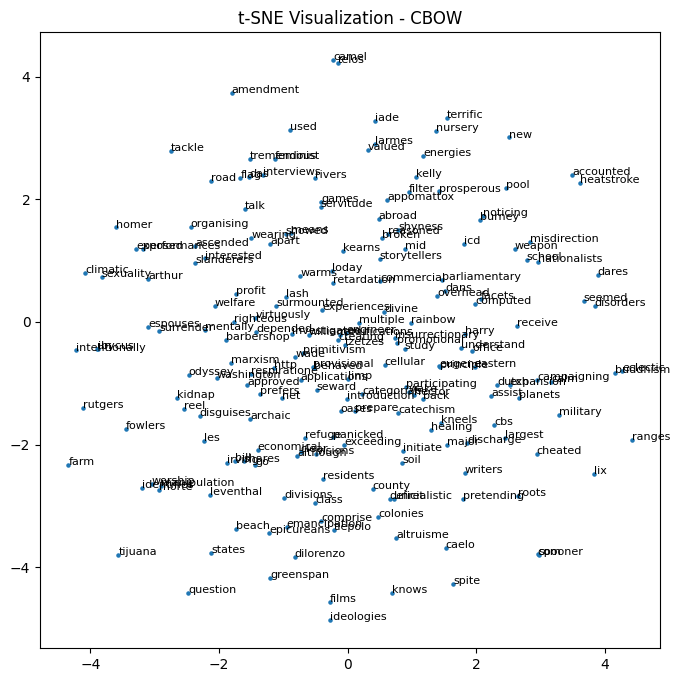

In [70]:
tsne_plot(cbow_subset, cbow_vocab_subset, "t-SNE Visualization - CBOW")

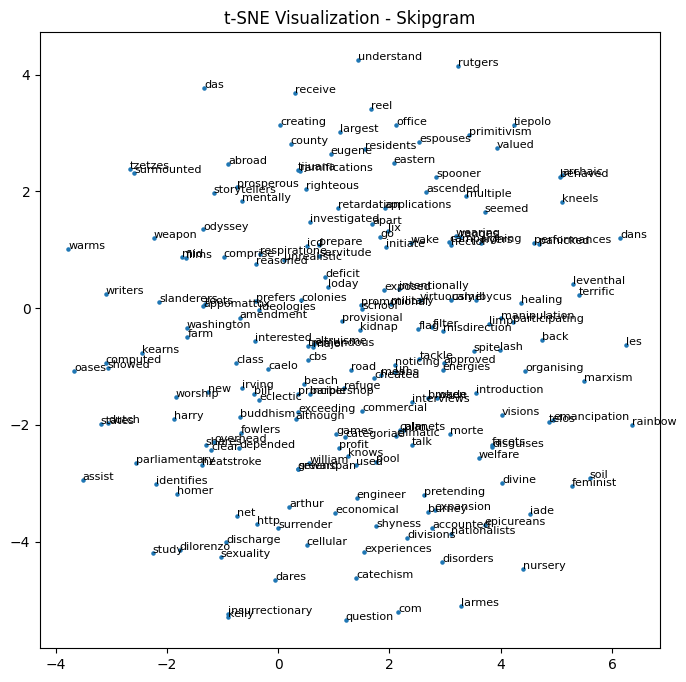

In [71]:
tsne_plot(skipgram_subset, cbow_vocab_subset, "t-SNE Visualization - Skipgram")


In this example, the same 200 word sub-sample was visualized using t-SNE for both our CBOW and Skipgram embeddings. Words closer together are more similar in meaning. Below are some specific examples which can be seen in the graphs above, with an example of how these might be used together on a Wikipedia article

#### CBOW
- "accounted" - "heatstroke" (heatstroke accoutned for 10% of deaths)
- "experiences" - "divine" (self-explanatory)
- "washington" - "farm" (George Washington grew up in a farm in Vermont)
- "application" - "approved" (also self-explanatory)
- "profit" - "welfare" (profit and welfare are both words used in macroeconomics discussions)

#### Skipgram
- "eugene" - "county" - "residents" (Eugene, a city with 176,000 residents, is the county seat of Lane County, Oregon)
- "http" - "net" (self-explanatory)
- "flag" - "filter" (these two words can be used interchangeably when talking about something like a system which has flags or filters for bad words, for example)
- "buddhism" - "worship" (also self-explanatory)
- "exceeding" - "commercial" (the commercial activity in the area was exceeding its resources)

# <font color= #bbc28d> **Bibliography** </font>

- Riva, M. (2025, February 13). _Word Embeddings: CBOW vs Skip-Gram_. Baeldung CS. https://www.baeldung.com/cs/word-embeddings-cbow-vs-skip-gram
- van der Maaten, L., Hinton, G. (2008) *Visualizing Data using t-SNE*. **Journal of Machine Learning Research**. https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf